# Predicting Parole Violators #

## Key Takeaways: ##

- ** A **


- ** B **


- ** C **


- ** D **

### The Problem ###

In many societies, inmates who are likely no longer a threat to society are released from prison on "parole." The parole system allows the inmate to complete the remainder of his/her sentence outside of prison and requires the parolee to abide by certain terms and conditions. Parolees who violate these terms and conditions may be re-incarcerated. 

Parole boards must identify those inmates who are good candidates for parole. "Good candidates" are inmates who are unlikely to commit additional crimes once released and will abide by the terms of his/her parole.

Can data analytics assist parole boards in their efforts to identify such people?

(source: MITx)

### The Study ###

Here, we build and validate a model that predicts whether or not an inmate is likely to violate the terms of his/her parole to assist parole boards to determine whom to release.

(source: MITx)

### The Data ###

We will use data from the United States 2004 National Corrections Reporting Program -- a nationwide census of parole releases. The scope of our analysis is limited to parolees who served 1) no more than 6 months in prison and 2) whose maximum sentence for all charges was less than 18 months. The dataset contains information about both parolees who completed their parole in 2004, as well as those who violated the terms of their parole in the same year.

Our dataset contains the following predictors: 

**male**: 1 if the parolee is male, 0 if female

**race**: 1 if the parolee is white, 2 otherwise

**age**: the parolee's age (in years) when he or she was released from prison

**state**: a code for the parolee's state. 2 is Kentucky, 3 is Louisiana, 4 is Virginia, and 1 is any other state. The three states were selected due to having a high representation in the dataset.

**time.served**: the number of months the parolee served in prison (limited by the inclusion criteria to not exceed 6 months).

**max.sentence**: the maximum sentence length for all charges, in months (limited by the inclusion criteria to not exceed 18 months).

**multiple.offenses**: 1 if the parolee was incarcerated for multiple offenses, 0 otherwise.

**crime**: a code for the parolee's main crime leading to incarceration. 2 is larceny, 3 is drug-related crime, 4 is driving-related crime, and 1 is any other crime.

**violator**: 1 if the parolee violated the parole, and 0 if the parolee completed the parole without violation.

(source: MITx)

### Data Structure ###

In [1]:
install.packages("ggplot2")
install.packages("corrplot")
install.packages("tidyverse")
install.packages("remotes")
library(remotes)
library(tidyverse)
install_github("randy3k/collections")
library(corrplot)
library(ggplot2)
library(collections)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Skipping install of 'collections' from a github remote, the SHA1 (117fff45) has not changed since last install.
  Use `force = TRUE` to force installation
corrplot 0.84 loaded


In [2]:
parole = read.csv("parole.csv")

In [3]:
str(parole)

'data.frame':	675 obs. of  9 variables:
 $ male             : int  1 0 1 1 1 1 1 0 0 1 ...
 $ race             : int  1 1 2 1 2 2 1 1 1 2 ...
 $ age              : num  33.2 39.7 29.5 22.4 21.6 46.7 31 24.6 32.6 29.1 ...
 $ state            : int  1 1 1 1 1 1 1 1 1 1 ...
 $ time.served      : num  5.5 5.4 5.6 5.7 5.4 6 6 4.8 4.5 4.7 ...
 $ max.sentence     : int  18 12 12 18 12 18 18 12 13 12 ...
 $ multiple.offenses: int  0 0 0 0 0 0 0 0 0 0 ...
 $ crime            : int  4 3 3 1 1 4 3 1 3 2 ...
 $ violator         : int  0 0 0 0 0 0 0 0 0 0 ...


### Data Summary ###

In [4]:
summary(parole)

      male             race            age            state      
 Min.   :0.0000   Min.   :1.000   Min.   :18.40   Min.   :1.000  
 1st Qu.:1.0000   1st Qu.:1.000   1st Qu.:25.35   1st Qu.:2.000  
 Median :1.0000   Median :1.000   Median :33.70   Median :3.000  
 Mean   :0.8074   Mean   :1.424   Mean   :34.51   Mean   :2.887  
 3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:42.55   3rd Qu.:4.000  
 Max.   :1.0000   Max.   :2.000   Max.   :67.00   Max.   :4.000  
  time.served     max.sentence   multiple.offenses     crime      
 Min.   :0.000   Min.   : 1.00   Min.   :0.0000    Min.   :1.000  
 1st Qu.:3.250   1st Qu.:12.00   1st Qu.:0.0000    1st Qu.:1.000  
 Median :4.400   Median :12.00   Median :1.0000    Median :2.000  
 Mean   :4.198   Mean   :13.06   Mean   :0.5363    Mean   :2.059  
 3rd Qu.:5.200   3rd Qu.:15.00   3rd Qu.:1.0000    3rd Qu.:3.000  
 Max.   :6.000   Max.   :18.00   Max.   :1.0000    Max.   :4.000  
    violator     
 Min.   :0.0000  
 1st Qu.:0.0000  
 Median :0.0000

Below we recode some of our numerical data as factors. This enhances readability and facilitaties explainability when dealing with primarily categorical datasets. We admit that factor variables can increase processing time. With low-dimensional data frames like ours, however, this should not be an issue. 

In [5]:
parole2 = as.data.frame(parole)
parole2$state = as.factor(parole2$state)
parole2$sex = as.factor(parole2$male)
parole2$race = as.factor(parole2$race)
parole2$violator = as.factor(parole2$violator)
parole2$male = NULL
parole2$multiple.offenses = as.factor(parole2$multiple.offenses)

In [6]:
parole2 = parole2 %>% mutate(sex=recode(sex, 
                        `1`='Male',
                        `0`="Female"),
                        race=recode(race, `1` = "White", `2` = "NonWhite"),
                        state=recode(state, `2` = "KY", `3` = "LA", `4` = "VA", `1` = "All Other States"),
                        multiple.offenses=recode(multiple.offenses, `1` = "Yes", `2` = "No"),
                        violator=recode(violator, `1` = "Yes", `0` = "No")
)

### Exploratory Data Analysis ###

The correlation matrix below suggests multicollinearity will not be a problem as we move towards modeling. The variables seem to have little to do with one another and, in all cases, fall below the .70 threshold we use for variable elimination. 

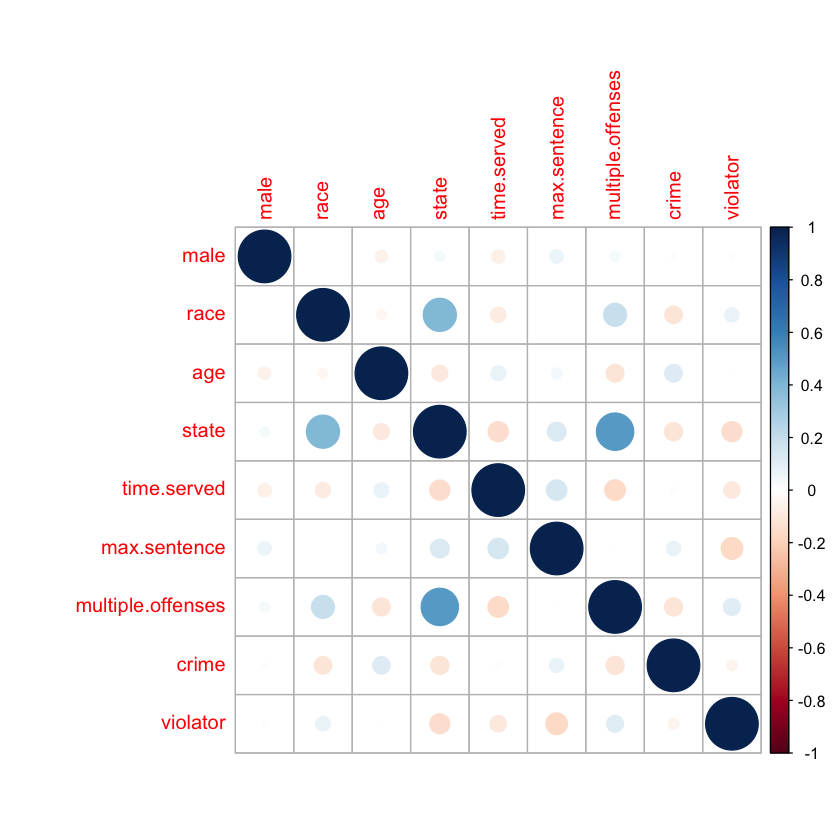

In [7]:
corrplot(cor(parole, use="complete.obs"))

Many of our predictors, in addition to our response variable, are categorical. So, we believe it would be fruitful to continue looking at the data, albeit through a different lens. 

In [8]:
state_sex = parole2 %>%
  group_by(state, sex) %>%
  summarise (n = n()) %>%
  mutate(freq = n / sum(n))
state_sex

state,sex,n,freq
<fct>,<fct>,<int>,<dbl>
All Other States,Female,23,0.1608392
All Other States,Male,120,0.8391608
KY,Female,35,0.2916667
KY,Male,85,0.7083333
LA,Female,18,0.2195122
LA,Male,64,0.7804878
VA,Female,54,0.1636364
VA,Male,276,0.8363636


In [9]:
state_race = parole2 %>%
  group_by(state, race) %>%
  summarise (n = n()) %>%
  mutate(freq = n / sum(n))
state_race

state,race,n,freq
<fct>,<fct>,<int>,<dbl>
All Other States,White,123,0.8601399
All Other States,NonWhite,20,0.1398601
KY,White,98,0.8166667
KY,NonWhite,22,0.1833333
LA,White,30,0.3658537
LA,NonWhite,52,0.6341463
VA,White,138,0.4181818
VA,NonWhite,192,0.5818182


In [11]:
# stacked bar chart
state_crime = parole2 %>%
  group_by(state, crime) %>%
  summarise (n = n()) %>%
  mutate(freq = n / sum(n))
state_crime

state,crime,n,freq
<fct>,<int>,<int>,<dbl>
All Other States,1,66,0.46153846
All Other States,2,9,0.06293706
All Other States,3,34,0.23776224
All Other States,4,34,0.23776224
KY,1,42,0.35000000
KY,2,10,0.08333333
KY,3,64,0.53333333
KY,4,4,0.03333333
LA,1,42,0.51219512


In [17]:
# side-by-side bar chart
state_MultiOffender = parole %>%
    group_by(state) %>%
    summarise_each(mean, multiple.offenses, violator)
state_MultiOffender

state,multiple.offenses,violator
<int>,<dbl>,<dbl>
1,0.2657343,0.13986014
2,0.1083333,0.11666667
3,0.6707317,0.45121951
4,0.7757576,0.02121212


In [23]:
# side by side bar chart
pct_timeServed = parole %>% 
    mutate(PCT_Served = time.served/max.sentence)%>%
    group_by(state) %>%
    summarise_each(mean, PCT_Served, violator)
pct_timeServed

state,PCT_Served,violator
<int>,<dbl>,<dbl>
1,0.3528689,0.13986014
2,0.3890079,0.11666667
3,0.5948477,0.45121951
4,0.2896138,0.02121212
